## HT Correction V3
Using the new method, the script was able to catch and fix about 81% of errors that occured. Another member of the coding team developed a filter to process the data in a manner that my ht_correction function could more easily digest. When running the script after the filter, it could catch about 90% of errors that occured.

In [1]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from numpy import diff
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *


In [2]:
# use unprocessed data to identify blinks
data = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data.csv')
filename = "2021.09.08_12-49-52_data.csv"

# filtering unprocessed data
Xcentroid = pd.Series(data['X-Centroid'])
Ycentroid = pd.Series(data['Y-Centroid'])
Xhead = pd.Series(data['X-Head'])
Yhead = pd.Series(data['Y-Head'])
Xtail = pd.Series(data['X-Tail'])
Ytail = pd.Series(data['Y-Tail'])
frames = pd.Series(data['Frame'])


In [3]:
# processed data
data_p = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data_processed.csv')

Xcentroid_p = pd.Series(data_p['X-Centroid'])
Ycentroid_p = pd.Series(data_p['Y-Centroid'])
Xhead_p = pd.Series(data_p['X-Head'])
Yhead_p = pd.Series(data_p['Y-Head'])
Xtail_p = pd.Series(data_p['X-Tail'])
Ytail_p = pd.Series(data_p['Y-Tail'])
frames_p = pd.Series(data_p['Frame'])

In [5]:
data.head()

,Unnamed: 0,Frame,Time,X-Centroid,Y-Centroid,X-Head,Y-Head,X-Tail,Y-Tail,X-Midpoint,Y-Midpoint,stimulation
0,0,0,0.000000,711,216,711,216,711,216,709,221,0.0
1,1,1,0.000000,711,213,711,213,711,213,711,217,0.0
2,2,2,0.299847,712,212,712,212,712,212,714,215,0.0
3,3,3,0.333166,711,213,711,213,711,213,714,215,0.0
4,4,4,0.366480,712,212,712,212,712,212,711,216,0.0


In [7]:
Xhead[2]

712

### Outline
1. identify first start and end points of a blink (assuming all starts point will be correct to begin with)
    - frame right before blink and frame right after it ends
    - store start and end in 2 separate lists
2. create 2 vectors from tail to head -> 1 for start pt and 1 for end pt
    - compare angles of the 2 vectors using Zainab's angle function 
3. identify which portions need to be swapped
    - if angle < 90 then find next start/end points
4. if angle > 90 then end point is an error
    - SAVE that point and it will be our new "start" point
    - now we want to find ending of NEXT blink and compare the angles if > 90 then it switches back so we swap everything in between
5. if angle < 90 for new comparison then we look for next blink

## Create Basic Functions

In [4]:
# find full position frame right before first blink (need full position frames so we can create vectors)
def find_start_blink(current, xc, yc, xh, yh, xt, yt, frames):
    for i in range(current, len(frames)):
        if (xc[i] == xh[i] == xt[i] != 0) and (yc[i] == yh[i] == yt[i] != 0):
            return i    
    return i-1

In [53]:
find_start_blink(3547, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frames)

3553

In [19]:
len(frames)

9540

In [6]:
# find full position frame right after last blink 
def find_end_blink(start, xc, yc, xh, yh, xt, yt, frames):
    for i in range(start, len(frames)):
        if (xc[i] == xh[i] == xt[i] != 0) and (yc[i] == yh[i] == yt[i] != 0):
            continue
            
        ### HJ: just in case that it reaches the end
        elif (i == len(frames) - 1):
            return i
        ###
        
        else:
            return i

# beware when using this function, the starting point must be the first frame blink occurs (not the one right before)

In [49]:
find_end_blink(3546, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frames)


3547

In [52]:
find_end_blink(3547, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frames)

3547

In [14]:
# angle between two vectors (in radians)
def compare_angle(start, end, xc, yc, xh, yh, xt, yt, frames):
    # vector = (xh[i]-xt[i], yh[i]-yt[i])
    v1 = [xh[start-1]-xt[start-1], yh[start-1]-yt[start-1]]
    v2 = [xh[end+1]-xt[end+1], yh[end+1]-yt[end+1]]
    
    ### HJ: just to make sure that the denominator is not 0 (like blink but not the locations don't change)
    if (np.linalg.norm(v1) * np.linalg.norm(v2) == 0):
        return 0
    ###
    
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    
    dot_product = np.dot(unit_v1, unit_v2)
    angle = np.arccos(dot_product)
    
    return angle

In [55]:
compare_angle(3547+1,3553,Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frames)

3.0251858274850982

In [78]:
# helper function to find end of error
def find_end_of_error(start, end, xc, yc, xh, yh, xt, yt, frame):
    # adjust start and end to full position frames not blinking frames
    start = start - 1
    end = end ### HJ: This could be problematic if your end frame reaches the "frame end range"
    
    # assume it's greater than pi/2
    counter = 1
    found_end = False 
    
    while found_end == False:
        if counter % 2 != 0:
            
            start = end
            end = find_start_blink(end, xc, yc, xh, yh, xt, yt, frame)  ### HJ: what if no blink? (last one)
            angle = compare_angle(start, end, xc, yc, xh, yh, xt, yt, frame)
            if angle > pi/2:
                end_of_error = end
                found_end = True
                continue
                
        ### HJ: what is the difference - oh end_blink?
        ###
        
        else: 
            
            start = end
            end = find_end_blink(end, xc, yc, xh, yh, xt, yt, frame)
            angle = (compare_angle(start, end, xc, yc, xh, yh, xt, yt, frame))
            if angle > pi/2:
                end_of_error = end
                found_end = True
                continue
        
        counter += 1 
    return end_of_error


In [57]:
find_end_of_error(3546, 3547, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frames) # should output 3553

3553

# Main Function
Combining all previous helper functions (find_start_blink, find_end_blink, compare_angle, find_end_of_error)

In [79]:
# main function that swaps the coordinates
def ht_correction(filename, current, xc, yc, xh, yh, xt, yt, frame):
    # setting up
    finish_swap = False
    
    xheadCorrected = xh.copy()
    yheadCorrected = yh.copy()
    xtailCorrected = xt.copy()
    ytailCorrected = yt.copy()
    
    start = find_start_blink(current, xc, yc, xh, yh, xt, yt, frame) 
    end = find_end_blink(start, xc, yc, xh, yh, xt, yt, frame) 
    angle = compare_angle(start, end, xc, yc, xh, yh, xt, yt, frame) 
    
    while finish_swap == False:
        
        if angle > (pi/2):
            # goes through one whole blink that has an ERROR and swapped necessary coordaintes
            start_of_error = end 
            end_of_error = find_end_of_error(start, end, xc, yc, xh, yh, xt, yt, frame) 

            xheadCorrected[start_of_error:end_of_error+1] = xt[start_of_error:end_of_error+1]
            yheadCorrected[start_of_error:end_of_error+1] = yt[start_of_error:end_of_error+1]
            xtailCorrected[start_of_error:end_of_error+1] = xh[start_of_error:end_of_error+1]
            ytailCorrected[start_of_error:end_of_error+1] = yh[start_of_error:end_of_error+1]
            
            ### HJ: you don't need this if you are doing the whole trajectory
            #   you can plot the whole thing
            ###
            
            # update current to check next blink
            current = end_of_error
            
            # reset to beginning of while loop
            start = find_start_blink(current, xc, yc, xh, yh, xt, yt, frame)
            end = find_end_blink(start, xc, yc, xh, yh, xt, yt, frame)
            angle = compare_angle(start, end, xc, yc, xh, yh, xt, yt, frame)
            
            # check to see if it reached end of frames
            if start == end == len(frame)-2:
                finish_swap = True
        
            continue
        
        # if the swap is a blink but NOT AN ERROR we need to move onto next blink
        else:
            
            # update current to check next blink
            current = end 
                
            start = find_start_blink(current, xc, yc, xh, yh, xt, yt, frame) 
            end = find_end_blink(start, xc, yc, xh, yh, xt, yt, frame)
            angle = compare_angle(start, end, xc, yc, xh, yh, xt, yt, frame)
            
            if start == end == len(frame)-2:
                finish_swap = True
            
            continue
            
    
#     # plot trajectory
#     fig, (ax1,ax2) = plt.subplots(1,2)
#     ax1.plot(xh_p, yh_p, "o", label="head") # blue
#     ax1.plot(xt_p, yt_p, "o", label="tail") # orange
#     plt.title("trajectory before HT error correction")
    
#     ax2.plot(xheadCorrected, yheadCorrected, "o",label="head") # blue
#     ax2.plot(xtailCorrected, ytailCorrected, "o",label="tail") # orange
#     plt.title("trajectory after HT error correction")
    
#     # plt.legend(loc="upper left")
#     plt.show
    
    # plot trajectory
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(xh, yh, label="head") # blue
    ax1.plot(xt, yt, label="tail") # orange
    plt.title("trajectory before HT error correction")
    
    ax2.plot(xheadCorrected, yheadCorrected,label="head") # blue
    ax2.plot(xtailCorrected, ytailCorrected,label="tail") # orange
    plt.title("trajectory after HT error correction")
    
    # plt.legend(loc="upper left")
    plt.show
    
    #filename for the corrected file:
    fileparts = filename.split('.')
    first_part = '.'.join(fileparts[0:len(fileparts) - 1])
    second_part = "_HTcorrected1"
    filename_corrected = '.'.join([first_part + second_part, fileparts[-1]]) #a way to rename the corrected file
    #below is a way to name the heading (first) row of the new csv file:
    newCorrectedArray = {
        #'xCentroid' : list(np.round(xc,decimals=1)),
        #'yCentroid' : list(np.round(xc,decimals=1)),
        'xHeadCorrected' : xheadCorrected,
        'yHeadCorrected' : yheadCorrected,
        'xTailCorrected' : xtailCorrected,
        'yTailCorrected' : ytailCorrected
    }
    #putting the actual data of corrected xy values in the array first:
    df = pd.DataFrame(newCorrectedArray)
    #and then put it in a csv of the new filename:
    df.to_csv(filename_corrected)

## Testing Code

In [12]:
# create subset of frames
Xcentroid1 = Xcentroid[3690:6300]
Ycentroid1 = Ycentroid[3690:6300]
Xhead1 = Xhead[3690:6300]
Yhead1 = Yhead[3690:6300]
Xtail1 = Xtail[3690:6300]
Ytail1 = Ytail[3690:6300]
frames1 = frames[3690:6300]

In [13]:
# create subset of processed data
Xtail1_p = Xtail_p[3690:6300]
Xhead1_p = Xhead_p[3690:6300]
Ytail1_p = Ytail_p[3690:6300]
Yhead1_p = Yhead_p[3690:6300]

/var/folders/3g/vjzcw6050n34kshmr3dgry980000gp/T/ipykernel_92449/2722634329.py:16: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product)


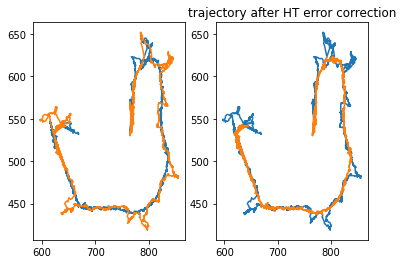

In [14]:
ht_correction(3690, 6270, filename, 3690, Xcentroid1, Ycentroid1, Xhead1, Yhead1, Xtail1, Ytail1, Xhead1_p, Yhead1_p, Xtail1_p, Ytail1_p, frames)


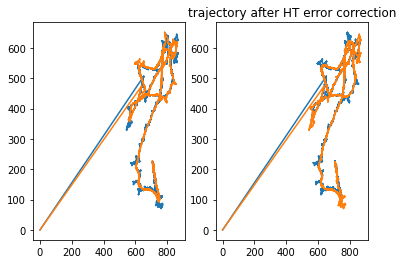

In [80]:
ht_correction(filename, 5, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frames)

In [33]:
# test on another file to make sure 

data1 = pd.read_csv('2021.10.04_15-08-01_W1118 Odor/2021.10.04_15-08-01_data.csv')
filename1 = "2021.10.04_15-08-01_data.csv"

# filtering unprocessed data
Xcentroid1 = pd.Series(data1['X-Centroid'])
Ycentroid1 = pd.Series(data1['Y-Centroid'])
Xhead1 = pd.Series(data1['X-Head'])
Yhead1 = pd.Series(data1['Y-Head'])
Xtail1 = pd.Series(data1['X-Tail'])
Ytail1 = pd.Series(data1['Y-Tail'])
frames1 = pd.Series(data1['Frame'])

In [46]:
data1.head()

,Unnamed: 0,Frame,Time,X-Centroid,Y-Centroid,X-Head,Y-Head,X-Tail,Y-Tail,X-Midpoint,Y-Midpoint,stimulation
0,0,0,0.000000,508,255,508,255,508,255,517,255,0.0
1,1,1,0.000000,507,255,507,255,507,255,518,255,0.0
2,2,2,0.333163,506,258,506,258,506,258,513,256,0.0
3,3,3,0.366478,506,258,506,258,506,258,515,256,0.0
4,4,4,0.399795,506,258,506,258,506,258,515,256,0.0


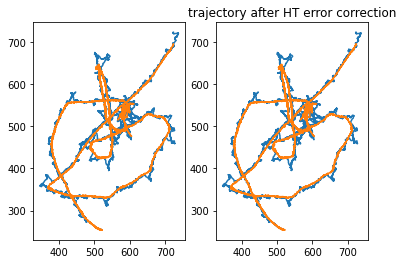

In [36]:
ht_correction(filename1, 2200, Xcentroid1, Ycentroid1, Xhead1, Yhead1, Xtail1, Ytail1, frames1)

In [52]:
len(frames1)

9540

In [49]:
find_start_blink(9435, Xcentroid1, Ycentroid1, Xhead1, Yhead1, Xtail1, Ytail1, frames1)

9538

In [51]:
find_end_blink(9538, Xcentroid1, Ycentroid1, Xhead1, Yhead1, Xtail1, Ytail1, frames1)

9538

In [34]:
# test on another file
data2 = pd.read_csv('2021.09.08_15-46-15_W1118_Solvent/2021.09.08_15-46-15_data.csv')
filename2 = "2021.09.08_15-46-15_data.csv"

# filtering unprocessed data
Xcentroid2 = pd.Series(data1['X-Centroid'])
Ycentroid2 = pd.Series(data1['Y-Centroid'])
Xhead2 = pd.Series(data1['X-Head'])
Yhead2 = pd.Series(data1['Y-Head'])
Xtail2 = pd.Series(data1['X-Tail'])
Ytail2 = pd.Series(data1['Y-Tail'])
frames2 = pd.Series(data1['Frame'])

In [56]:
data2.head()

,Unnamed: 0,Frame,Time,X-Centroid,Y-Centroid,X-Head,Y-Head,X-Tail,Y-Tail,X-Midpoint,Y-Midpoint,stimulation
0,0,0,0.000000,821,180,821,180,821,180,822,180,0.0
1,1,1,0.000000,822,181,822,181,822,181,818,181,0.0
2,2,2,0.166582,824,180,824,180,824,180,825,181,0.0
3,3,3,0.199897,824,181,824,181,824,181,818,181,0.0
4,4,4,0.233214,824,181,824,181,824,181,824,181,0.0


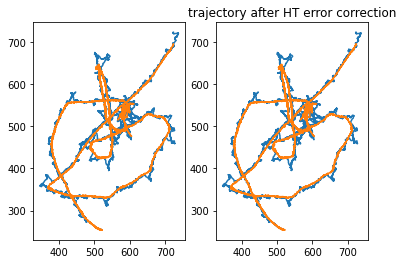

In [81]:
ht_correction(filename2, 100, Xcentroid2, Ycentroid2, Xhead2, Yhead2, Xtail2, Ytail2, frames2)

In [59]:
find_start_blink(9435, Xcentroid2, Ycentroid2, Xhead2, Yhead2, Xtail2, Ytail2, frames2)

9538

## Han's Filter

In [21]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import json
import tkinter 

def process_pivr_csvfile_with_raw_version2(pathinfo, csvdata, filename):
    os.chdir(pathinfo)
    exp_settings = open('experiment_settings.json')  # insert path to experiment settings file.
    exp_set = json.load(exp_settings)
    px_per_mm = exp_set["Pixel per mm"]
    framerate = exp_set["Framerate"]
    xhraw = csvdata['X-Head']  # for ht err corr reference later in ht module below.
    yhraw = csvdata['Y-Head']
    xtraw = csvdata['X-Tail']
    ytraw = csvdata['Y-Tail']
    if np.isnan(csvdata['Time'][len(csvdata) - 1]):  # dropping the last row as it is incomplete in some files.
        csvdata = csvdata[:-1]

    ###hard coded variables:
    winsize = 61  # window size for SG filter.
    p_order = 4  # polynomial order between 2-4 is ok for SG filter. Currently, SG filter is the only filter option here

    def SG_filter(arr, winsize, p_order):  # currently, the only filter option in this script.
        arrfilt = signal.savgol_filter(arr, winsize, p_order)
        return arrfilt

    def remove_0rows_from_file(file):
        def find_indices_with_num(arr, num):
            # zero_locations = np.where(arr == 0)
            locations = []
            for k in range(len(arr)):
                if arr[k] == num:
                    locations.append(k)
            return locations
        t = file['Time']
        locations = find_indices_with_num(t, 0)
        newfile = file.drop(file.index[locations])
        return newfile

    csvdata2 = remove_0rows_from_file(csvdata)  # storing original data without 0s rows in the time col.

    def get_filtered_file_cols(file):
        xcfilt = SG_filter(file['X-Centroid'], winsize, p_order)
        ycfilt = SG_filter(file['Y-Centroid'], winsize, p_order)
        xhfilt = SG_filter(file['X-Head'], winsize, p_order)
        yhfilt = SG_filter(file['Y-Head'], winsize, p_order)
        xtfilt = SG_filter(file['X-Tail'], winsize, p_order)
        ytfilt = SG_filter(file['Y-Tail'], winsize, p_order)
        xmfilt = SG_filter(file['X-Midpoint'], winsize, p_order)
        ymfilt = SG_filter(file['Y-Midpoint'], winsize, p_order)
        return xcfilt, ycfilt, xhfilt, yhfilt, xtfilt, ytfilt, xmfilt, ymfilt

    # storing filtered cols from csvdata2 (0s rows removed dataframe) -
    xcfilt, ycfilt, xhfilt, yhfilt, xtfilt, ytfilt, xmfilt, ymfilt = get_filtered_file_cols(csvdata2)

    def remove_edge_noise_from_file(x, y):
        height = 3 / px_per_mm  # threshold incremental dist value to find jumps(empirical observations on a few files).
        range_lower = 0.07 / px_per_mm  # highres. lower range for data (incremental distance)
        range_upper = 0.3 / px_per_mm  # highres. upper range for data (incremental dis)
        min_traj_len = 10 * framerate  # seconds*frame per second. minimum trajectory length between heights.
        #THE VARIABLE BELOW () IS FINE-TUNEABLE that is, it can be modified as directed below in speific cases:
        max_ok_separation = 4.5 * framerate#sec*fps (frames) acceptable separation limit between segments for stitching.
        # TWEAK 'max_ok_separation' PARAMETER FOR FINE TUNING THE THRESHOLD FOR ARENA EDGE/BEGINNING NOISE.
        # for high noise acceptance->max-ok-sep(>3 or about 4.5); for very tight control on taking the trajectories at
        # the risk of truncating the trajectories too short, aim for max_ok_sep. values around 1 (0.75, 1.2, 1.5 etc).
        # My suggestion is -  start with 4.5 to get large usable trajectories and in specific cases where the boundary
        # noise doesn't go away properly, reduce the max_ok_separation to 1.5 or 1.2 or even less to see if that removes
        # the extra noise.
        # CHANGE THE FINE-TUNABLE VARIABLES ONLY FOR SPECIFIC CASES AND NOT FOR THE ENTIRE DATA SET.
        def increment_dis(x, y):
            dx = np.diff(x)
            dy = np.diff(y)
            id = ((dx) ** 2 + (dy) ** 2) ** (1 / 2)
            # for keeping the array length same with original
            np.insert(id, 0, 0)
            return id

        def find_inter_condition_segment_locations(arr, condition, symbol):  # symbol could be '>', '<' or '='
            conditional_locations = []
            for k in range(len(arr)):
                if symbol == '=' and arr[k] == condition:
                    conditional_locations.append(k)
                if symbol == '>' and arr[k] > condition:
                    conditional_locations.append(k)
                    # print(conditional_locations)
                if symbol == '<' and arr[k] < condition:
                    conditional_locations.append(k)
            # if last frame is not included
            if not np.any(conditional_locations):
                print('no edge noise or jumps in ' + filename)
                conditional_locations = []
            else:
                if conditional_locations[-1] != len(arr) - 1 and conditional_locations != []:
                    conditional_locations.append(len(arr) - 1)  # to include the last frame if it is not already included
                 # if initial frame to be included
                if conditional_locations[0] != 0 and conditional_locations != []:
                    conditional_locations.insert(0, 0)  # to include the first frame if it is not already included
            # print('cloci-last element: ' + str(len(conditional_locations)))
            #print('conditional_locations' + str(conditional_locations))
            return conditional_locations  # cond locs returns empty if no extreme values(condition) found.

        def selecting_proper_traj_segments(arr, c_loc):  # takes in test-array and conditional_locations
            # selecting for min len criterion and range-upper&lower
            if c_loc == []:
                proper_traj_segment_locations = [0, len(arr)-1]  # take the length of csv file after basic 0s removal.
                print('No edge noise or jumps in ' + filename)
            elif len(c_loc) == 1:  # if there was only one case of extreme jump
                print('conditional_locations is of length 1')
            elif len(c_loc) > 1:
                # print('c_loc: ' + str(c_loc))
                diff_c_loc = np.diff(c_loc)
                # print('diff-c-loc: ' + str(diff_c_loc))
                # print(diff_c_loc)
                arr_collections = []
                for k in range(len(diff_c_loc)):  # [1,3]
                    if diff_c_loc[k] > min_traj_len and np.mean(arr[c_loc[k]: c_loc[k + 1]]) > range_lower \
                            and np.mean(arr[c_loc[k]:c_loc[k + 1]]) < range_upper:
                        arr_collections = arr_collections + [c_loc[k], c_loc[k + 1]]
                # print('arr-coll: ' + str(arr_collections))
                diff_arr_coll = np.diff(arr_collections)
                # print('diff-arr-coll: ' + str(diff_arr_coll))
                for j in range(len(diff_arr_coll)):
                    if diff_arr_coll[j] < max_ok_separation:  # to avoid breaking traj. for a short dur. noise
                        arr_collections[j:j + 2] = []
                        # print('arr-coll after removing short: ' + str(arr_collections))
                diff2_arr_coll = np.diff(arr_collections)
                # print('diff2-arr-coll: ' + str(diff2_arr_coll))
                # final traj segment that is proper:
                if not np.any(diff2_arr_coll):
                    proper_traj_segment_locations = [0, len(arr)-1]
                    #print('diff2_arr_coll is empty')
                    #exit()
                else:
                    #print('diff2-arr-coll: ' + str(diff2_arr_coll))
                    maxval = max(diff2_arr_coll)
                    # print('maxval: ' + str(maxval))
                    # print('c loc: ' + str(c_loc))
                    # print('arr_coll: ' + str(arr_collections))
                    id_tuple = np.where(diff2_arr_coll == maxval)  # it was arr_collections.index(maxval)
                    idx = id_tuple[0][0]
                    # print(idx)
                    proper_traj_segment_locations = [arr_collections[idx],
                                                 arr_collections[idx + 1]]  # it was [idx-1] and [idx]
            print('proper_traj_segment_locations ' + str(proper_traj_segment_locations))
            return proper_traj_segment_locations
        
        incD = increment_dis((x / px_per_mm), (y / px_per_mm)) # not taking px_per_mm would make the height value
                                                               # ineffective.
        conditional_loci = find_inter_condition_segment_locations(incD, height, '>')
        trajseg = selecting_proper_traj_segments(incD, conditional_loci)  # frames good outside the edge-noise.
        return trajseg
    
    trajseg = remove_edge_noise_from_file(xcfilt, ycfilt)
    #print(trajseg)
    
    newcsvdata = pd.DataFrame({
                'Frame': csvdata2['Frame'][trajseg[0]:trajseg[1]],
                'Time': csvdata2['Time'][trajseg[0]:trajseg[1]],
                'X-Centroid': csvdata2['X-Centroid'][trajseg[0]:trajseg[1]],
                'Y-Centroid': csvdata2['Y-Centroid'][trajseg[0]:trajseg[1]],  #
                'X-Head': csvdata2['X-Head'][trajseg[0]:trajseg[1]],
                'Y-Head': csvdata2['Y-Head'][trajseg[0]:trajseg[1]],
                'X-Tail': csvdata2['X-Tail'][trajseg[0]:trajseg[1]],
                'Y-Tail': csvdata2['Y-Tail'][trajseg[0]:trajseg[1]],
                'X-Midpoint': csvdata2['X-Midpoint'][trajseg[0]:trajseg[1]],
                'Y-Midpoint': csvdata2['Y-Midpoint'][trajseg[0]:trajseg[1]],
                'stimulation': csvdata2['stimulation'][trajseg[0]:trajseg[1]]
            })

    #print(newcsvdata[:][1:10])
    
    
    def HT_err_corr_on_file(newcsvdata, filename):
        # THE VARIABLES BELOW ARE FINE-TUNEABLE that is, it can be modified as directed below in specific cases:
        fraction_body_length = 0.2 #fractions work; keep it less than 1. This threshold can be changed. #Default = 0.2
        next_frame_gap = 60  # Use only integer values. gap_value * fps  # for sampling two well apart frames for
        # ht-error. This threshold can be changed. #Default next_frame_gap = 60 (twice of fps)
        #CHANGE THE FINE-TUNABLE VARIABLES ONLY FOR SPECIFIC CASES AND NOT FOR THE ENTIRE DATA SET.
        
        ###
        csv_raw = newcsvdata.copy()
        ###
        
        class fileIn:
            def __init__(self, file):
                self.framerate = framerate
                self.frame = file['Frame']
                self.time = file['Time']
                self.xcFilt = signal.savgol_filter(file['X-Centroid'], winsize, p_order)
                self.ycFilt = signal.savgol_filter(file['Y-Centroid'], winsize, p_order)
                self.xhFilt = signal.savgol_filter(file['X-Head'], winsize, p_order)
                self.yhFilt = signal.savgol_filter(file['Y-Head'], winsize, p_order)
                self.xtFilt = signal.savgol_filter(file['X-Tail'], winsize, p_order)
                self.ytFilt = signal.savgol_filter(file['Y-Tail'], winsize, p_order)
                self.xmFilt = signal.savgol_filter(file['X-Midpoint'], winsize, p_order)
                self.ymFilt = signal.savgol_filter(file['Y-Midpoint'], winsize, p_order)
                self.stimulation = file['stimulation']

        # I wrote this tiny function to call the content from the class function above
        def filter_PiVRcsvfile():
            return fileIn(newcsvdata)
        f = filter_PiVRcsvfile()  # this keeps the csv and json variables available to all functions below.

        # function to calculate "max" body length (Zainab's work)-
        def max_body_length(xhead, yhead, xtail, ytail):
            HTdist = (((xhead - xtail) ** 2 + (yhead - ytail) ** 2) ** (1 / 2))
            bodylength = max(
                HTdist)  # find max HT distance to set as the body length#assuming, filtered vales will not have
            # erroneous values in the HT length values.
            return bodylength

        curl_threshold = (fraction_body_length) * max_body_length(f.xhFilt, f.yhFilt, f.xtFilt,
                                                 f.ytFilt)  # threshold should be less than 20% body length based
                                                            # on Zainab's results.

        # this function binarized the array based on whether the animal is curling (1s) or not curling (0s):
        def Dis_condition_based_binary_array(x1, y1, x2, y2):
            Dht = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1 / 2)
            binarized_array = []
            
            for k in range(len(Dht)):
                if Dht[k] < curl_threshold: #CURLING THRESHOLD SHOULD BE OBJECTIVELY DEFINED (earlier it was 3).
                    binarized_array.append(1)
                else:
                    binarized_array.append(0)
            # binarized_array.pop(0)
            return binarized_array

        ba = Dis_condition_based_binary_array(f.xhFilt, f.yhFilt, f.xtFilt,
                                              f.ytFilt)  # binary array for curls and no curls.

        # print(ba)
        # print(len(ba)-1)

        # Again I used class(though not necessary and a bit overkill to use class for simple tasks),
        # to get the locations of where the curls start and ends (denoted as starts of 0s and ends of 0s etc).
        class extractInfoFromBinaryArr:
            def __init__(self, binary_arr):
                starts0 = []
                ends0 = []
                starts1 = []
                ends1 = []
                seglen0 = []
                seglen1 = []
                for i in range(len(binary_arr) - 1):
                    if i == 0 and binary_arr[i] == 0:
                        starts0.append(i)
                    if i == 0 and binary_arr[i] == 1:
                        starts1.append(i)
                    if i == len(binary_arr) - 2 and binary_arr[i+1] == 0:
                        ends0.append(i + 1)
                    if i == len(binary_arr) - 2 and binary_arr[i+1] == 1:
                        ends1.append(i + 1)
                    if binary_arr[i] == 1 and binary_arr[i + 1] == 0 and i <= (len(binary_arr) - 2):
                        starts0.append(i + 1)
                        ends1.append(i)
                    elif binary_arr[i] == 0 and binary_arr[i + 1] == 1 and i <= (len(binary_arr) - 2):
                        ends0.append(i)
                        starts1.append(i + 1)
                #print('starts0 ' + str(starts0))
                #print('ends0 ' + str(ends0))
                #print('starts1 ' + str(starts1))
                #print('ends1 ' + str(ends1))
                seglen0 = np.subtract(np.array(ends0), np.array(starts0))
                seglen1 = np.subtract(np.array(ends1), np.array(starts1))
                self.starts0 = starts0
                self.ends0 = ends0
                self.starts1 = starts1
                self.ends1 = ends1
                self.seglen0 = seglen0
                self.seglen1 = seglen1

        # same logic as above to extract information from the class method above
        def binary_arr_starts_ends():
            return extractInfoFromBinaryArr(ba)

        ba_f = binary_arr_starts_ends()  # binary array features

        # print(binary_arr_features.starts0)

        # because we need to calculate distances between two points in 2d a lot, a simple function for this small task:
        def dis(x1, y1, x2, y2):
            distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1 / 2)
            return distance

        # below is the method which decides if there is an HT exchange error at the beginning of a given inter-curl
        # segment. This function takes many inputs and the main function which tests for the presence of ht error is
        # written within this function.
        def ht_error_correction_module(filename, starts0, ends0, xc, yc, xh, yh, xt, yt, frame, time, xm, ym,
                                       stimulation, fps, xhraw, yhraw, xtraw, ytraw):
            '''
            xheadCorrected = xh.copy()  # xh ###concern that David warned us about #late edit by Nitesh
            yheadCorrected = yh.copy()  # yh ###concern that David warned us about
            xtailCorrected = xt.copy()  # xt ###concern that David warned us about
            ytailCorrected = yt.copy()  # yt ###concern that David warned us about
            '''
            
            ###
            newcsvdata_copy = newcsvdata.copy()
            xheadCorrected = newcsvdata_copy['X-Head'].to_numpy()
            yheadCorrected = newcsvdata_copy['Y-Head'].to_numpy()
            xtailCorrected = newcsvdata_copy['X-Tail'].to_numpy()
            ytailCorrected = newcsvdata_copy['Y-Tail'].to_numpy()
            
            xheadCorrected_copy = xheadCorrected.copy()
            yheadCorrected_copy = yheadCorrected.copy()
            xtailCorrected_copy = xtailCorrected.copy()
            ytailCorrected_copy = ytailCorrected.copy()
            ###
            
            # here plotting the figure which has no correction done yet:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.plot(xhraw, yhraw, 'r', label='head')
            ax1.plot(xtraw, ytraw, 'b', label='tail')
            ax1.set_xlabel('x axis')
            ax1.set_ylabel('y axis')
            ax1.set_title('trajectory before filter and HT error correction')

            # this is the main function which tests for the presence of head tail error between two locations of the
            # larvae (one position at the beginning of inter curl segment and second frame, 60 steps further down).
            def HTerror_corr_method1(fr1, fr2, j):
                distance1 = dis(xc[fr1], yc[fr1], xt[fr2], yt[fr2])
                distance2 = dis(xc[fr1], yc[fr1], xh[fr2], yh[fr2])
                # if error is found, exchange head and tail values thus "correcting" the ht error:
                if distance1 > distance2:
                    ### apply to the raw data
                    xheadCorrected[starts0[j]:ends0[j] + 1] = xtailCorrected_copy[starts0[j]:ends0[j] + 1]
                    yheadCorrected[starts0[j]:ends0[j] + 1] = ytailCorrected_copy[starts0[j]:ends0[j] + 1]
                    xtailCorrected[starts0[j]:ends0[j] + 1] = xheadCorrected_copy[starts0[j]:ends0[j] + 1]
                    ytailCorrected[starts0[j]:ends0[j] + 1] = yheadCorrected_copy[starts0[j]:ends0[j] + 1]
                    ###

            for n in range(len(starts0)):
                if starts0[n] + next_frame_gap < len(xc):
                    HTerror_corr_method1(starts0[n], starts0[n] + next_frame_gap, n)  # ~60 frames apart between two
                    # larval positions, to estimate whether larva has inverted the proper head tail position.
                else:
                    HTerror_corr_method1(starts0[n], len(xc) - 1, n)
                xheadCorrected = list(np.round(xheadCorrected, decimals=1))
                yheadCorrected = list(np.round(yheadCorrected, decimals=1))
                xtailCorrected = list(np.round(xtailCorrected, decimals=1))
                ytailCorrected = list(np.round(ytailCorrected, decimals=1))
            # plotting basic trajectories to visualize the correction:
            ax2.plot(xheadCorrected, yheadCorrected, 'r', label='head')
            ax2.plot(xtailCorrected, ytailCorrected, 'b', label='tail')
            ax2.set_xlabel('x axis')
            ax2.set_ylabel('y axis')
            ax2.set_title('trajectory after filters + HT correction')
            plt.suptitle('trajectory before and after filtering and HT error correction')
            fig.set_figheight(6)
            fig.set_figwidth(11)
            handles, labels = ax1.get_legend_handles_labels()  # or ax2
            fig.legend(handles, labels, loc='upper left')
            fig.savefig('trajectory before and after filter and HT error correction.png')
            # plt.show(block=False)  #to unblock the session to be able to close the window
            # plt.time.sleep(5)
            plt.close(fig)

            # filename for the corrected file:
            fileparts = filename.split('.')
            first_part = '.'.join(fileparts[0:len(fileparts) - 1])
            second_part = "_processed_raw"
            filename_corrected = '.'.join([first_part + second_part, fileparts[-1]])  # to rename the corrected file.
            # below is a way to name the heading (first) row of the new csv file:
            newCorrectedArray = {
                'Frame': frame,
                'Time': time,
                'X-Centroid': np.nan,
                'Y-Centroid': np.nan,
                'X-Head': np.nan,
                'Y-Head': np.nan,
                'X-Tail': np.nan,
                'Y-Tail': np.nan,
                'X-Midpoint': np.nan,
                'Y-Midpoint': np.nan,
                'stimulation': stimulation,
                'X-Head_HT_Corrected': xheadCorrected,
                'Y-Head_HT_Corrected': yheadCorrected,
                'X-Tail_HT_Corrected': xtailCorrected,
                'Y-Tail_HT_Corrected': ytailCorrected,
            }

            
            add_nan = 0  # CHANGE IT TO 1 IF YOU WANT TO ADD NaNs TO EQUALIZE LENGTH OF ARRAYS TO ORIGINAL VALUE.
            if add_nan == 0:
                # putting the actual data of corrected xy values in the array first:
                df = pd.DataFrame(newCorrectedArray)
                df.update(csv_raw)
                # and then put it in a csv of the new filename:
                df.to_csv(filename_corrected)
            elif add_nan == 1:    # if for some reason, you want arrays of same length:
                df1 = pd.DataFrame(newCorrectedArray)
                nan_len = len(csvdata['X-Centroid'])-1 -len(xheadCorrected) # length of nans to be added
                nan_arr = []
                for n in range(nan_len):
                    nan_arr.append(np.nan)
                print(nan_arr[0:20])
                df2 = pd.DataFrame({'Frame': nan_arr,
                        'Time': nan_arr,
                        'X-Centroid': nan_arr,
                        'Y-Centroid': nan_arr,
                        'X-Head': nan_arr,
                        'Y-Head': nan_arr,
                        'X-Tail': nan_arr,
                        'Y-Tail': nan_arr,
                        'X-Midpoint': nan_arr,
                        'Y-Midpoint': nan_arr,
                        'stimulation': nan_arr})
                df3 = pd.concat([df1, df2], ignore_index=True)
                df3.reset_index()
                df3.to_csv(filename_corrected)




        ht_error_correction_module(filename, ba_f.starts0, ba_f.ends0, f.xcFilt, f.ycFilt, f.xhFilt, f.yhFilt, f.xtFilt,
                                   f.ytFilt, f.frame, f.time, f.xmFilt, f.ymFilt, f.stimulation, f.framerate, xhraw,
                                   yhraw, xtraw, ytraw)
    #now, use the Htmodule of procesing script(now called ht-err-corr-onfile)which was the mainfun in only HT-corr code:
    HT_err_corr_on_file(newcsvdata, filename)

In [63]:
process_pivr_csvfile_with_raw_version2('2021.09.08_12-49-52_W1118_Solvent', data, "12-49-52")

no edge noise or jumps in 12-49-52
No edge noise or jumps in 12-49-52
proper_traj_segment_locations [0, 9526]


In [23]:
new_raw = pd.read_csv('/Users/stellajia/Desktop/UCSB/Louis_Lab/ht_correction/2021.09.08_12-49-52_W1118_Solvent/_processed_raw.12-49-52')
new_raw.to_csv('_processed_raw_12-49-52.csv')




In [24]:
xh = new_raw["X-Head_HT_Corrected"]
yh = new_raw["Y-Head_HT_Corrected"]
xt = new_raw["X-Tail_HT_Corrected"]
yt = new_raw["Y-Tail_HT_Corrected"]
frame_new = new_raw["Frame"]
frame_new

0          2
1          3
2          4
3          5
4          6
        ... 
9521    9523
9522    9524
9523    9525
9524    9526
9525    9527
Name: Frame, Length: 9526, dtype: int64

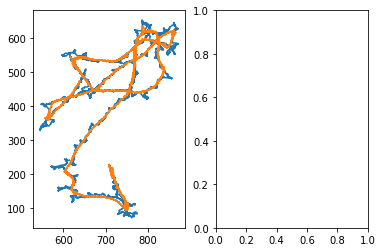

In [25]:
fig, (ax1,ax2) = plt.subplots(1, 2)

ax1.plot(xh, yh, label="head") # blue
ax1.plot(xt, yt, label="tail")
plt.show()

In [77]:
len(xh)

9526

In [81]:
len(frames[:9526])

9526

### Overlap Han's filter with my own code to see how well it works

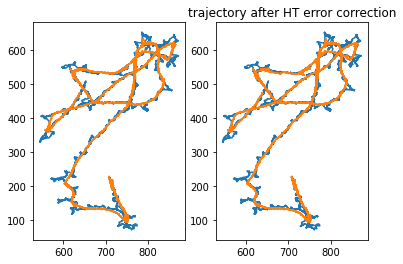

In [41]:
ht_correction(filename, 100, Xcentroid, Ycentroid, xh, yh, xt, yt, frame_new)

In [27]:
# testing another trajectory
new_raw1 = pd.read_csv('/Users/stellajia/Desktop/UCSB/Louis_Lab/ht_correction/2021.10.04_15-08-01_W1118 Odor/_processed_raw.15-08-01')
new_raw1.to_csv('_processed_raw.15-08-01.csv')




In [28]:
xh1 = new_raw1["X-Head_HT_Corrected"]
yh1 = new_raw1["Y-Head_HT_Corrected"]
xt1 = new_raw1["X-Tail_HT_Corrected"]
yt1 = new_raw1["Y-Tail_HT_Corrected"]
frame_new1 = new_raw1["Frame"]

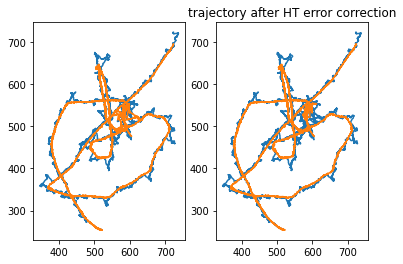

In [40]:
ht_correction(filename, 100, Xcentroid1, Ycentroid1, xh1, yh1, xt1, yt1, frame_new1)

In [133]:
# edit csv file
data_copy1 = pd.read_csv('/Users/stellajia/Desktop/UCSB/Louis_Lab/ht_correction/2021.10.04_15-08-01_W1118 Odor_og-filter/2021.10.04_15-08-01_data.csv')

# chop off original file so it matches new raw file
data_copy1.drop(data_copy1.tail(18).index, axis=0, inplace=True)
# data_copy1['X-Head'][2:] = new_raw1['X-Head_HT_Corrected']

len(data_copy1)

0       824
1       824
2       824
3       825
4       825
       ... 
9515    348
9516    346
9517    349
9518    350
9519    349
Name: X-Head_HT_Corrected, Length: 9520, dtype: int64

In [134]:
len(data_copy1[2:])
data_copy1['X-Head'][2:] = new_raw1['X-Head_HT_Corrected']

/var/folders/3g/vjzcw6050n34kshmr3dgry980000gp/T/ipykernel_92449/1813990110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_copy1['X-Head'][2:] = new_raw1['X-Head_HT_Corrected']


In [141]:
data_copy1.tail()

,Unnamed: 0,Frame,Time,X-Centroid,Y-Centroid,X-Head,Y-Head,X-Tail,Y-Tail,X-Midpoint,Y-Midpoint,stimulation
9517,9517,9517,0.0,0,0,348,0,0,0,0,0,0.0
9518,9518,9518,0.0,0,0,346,0,0,0,0,0,0.0
9519,9519,9519,0.0,0,0,349,0,0,0,0,0,0.0
9520,9520,9520,0.0,0,0,350,0,0,0,0,0,0.0
9521,9521,9521,0.0,0,0,349,0,0,0,0,0,0.0


In [37]:
# testing another trajectory
new_raw2 = new_raw1 = pd.read_csv('/Users/stellajia/Desktop/UCSB/Louis_Lab/ht_correction/2021.09.08_15-46-15_W1118_Solvent/_processed_raw.15-46-15')
new_raw2.to_csv('_processed_raw.15-46-15.csv')




In [38]:
xh2 = new_raw2["X-Head_HT_Corrected"]
yh2 = new_raw2["Y-Head_HT_Corrected"]
xt2 = new_raw2["X-Tail_HT_Corrected"]
yt2 = new_raw2["Y-Tail_HT_Corrected"]
frame_new2 = new_raw2["Frame"]

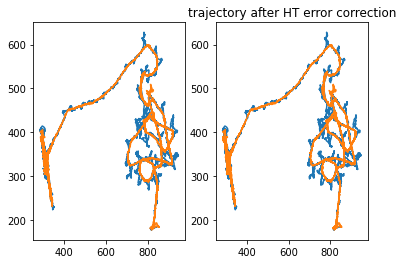

In [39]:
ht_correction(filename, 100, Xcentroid2, Ycentroid2, xh2, yh2, xt2, yt2, frame_new2)

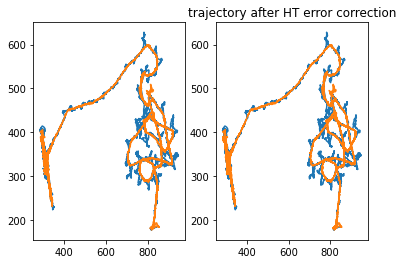

In [153]:
ht_correction(filename, 4900, Xcentroid2, Ycentroid2, xh2, yh2, xt2, yt2, frame_new2)